# Train a deep SNN on the SHD Dataset

In [18]:
import os
import sys

sys.path.append("../../stork")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns


import stork
from stork.datasets import HDF5Dataset, DatasetView

from stork.loss_stacks import MeanOfSoftmaxCrossEntropy, SumOfSoftmaxCrossEntropy
from stork.layers import Layer
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup, AverageReadouts, FilterLIFGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import (
    FluctuationDrivenCenteredNormalInitializer,
    DistInitializer,
    KaimingNormalInitializer
)

## Load Dataset

***To locally run this notebook on your system, download the SHD dataset from: [https://zenkelab.org/datasets/](https://zenkelab.org/datasets/).***
*We need 'shd_train.h5' and 'shd_test.h5'. Move the downloaded files into a folder `data/datasets/hdspikes` in this repo, or change the `datadir` variable below. 

In [19]:
datadir = "/tungstenfs/scratch/gzenke/datasets/hdspikes"

Next, we specify the Dataset Parameters.

In [20]:
nb_inputs = 700
duration = 0.7
time_step = dt = 2e-3
nb_time_steps = int(duration / time_step)
time_scale = 1
unit_scale = 1
validation_split = 0.9

sigma_u_augment = 10
dropout_p = 0.4

In [21]:
train_gen_kwargs = dict(
    nb_steps=nb_time_steps,
    time_scale=time_scale / time_step,
    unit_scale=unit_scale,
    nb_units=nb_inputs,
    preload=True,
    precompute_dense=False,
    unit_permutation=None,
    sigma_u_uniform=sigma_u_augment,
)

test_gen_kwargs = dict(
    nb_steps=nb_time_steps,
    time_scale=time_scale / time_step,
    unit_scale=unit_scale,
    nb_units=nb_inputs,
    preload=True,
    precompute_dense=False,
    unit_permutation=None,
    sigma_u_uniform=0,
)

In [22]:
train_dataset = HDF5Dataset(os.path.join(datadir, "shd_train.h5"), **train_gen_kwargs)

# Split into train and validation set
mother_dataset = train_dataset
elements = np.arange(len(mother_dataset))
np.random.shuffle(elements)
split = int(validation_split * len(mother_dataset))
valid_dataset = DatasetView(mother_dataset, elements[split:])
train_dataset = DatasetView(mother_dataset, elements[:split])

test_dataset = HDF5Dataset(os.path.join(datadir, "shd_test.h5"), **test_gen_kwargs)

## Set up the model

In [51]:
# Model Parameters
batch_size = 256
beta = 5
device = torch.device("cuda:1")
dtype = torch.float
dropout_p = 0.4

nb_hidden_units = 1024
nb_groups = nb_hidden_units
nb_hidden_layers = 1
nb_classes = 20
rec = True
stochastic = True
nb_readouts = 1

tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = 200e-3

tau_filter = 40e-3
nb_filters = 10


init_hetero = True

lr = 5e-3
nb_epochs = 30

In [52]:
act_fn = stork.activations.CustomSpike
if stochastic:
    act_fn.escape_noise_type = "sigmoid"
else:
    act_fn.escape_noise_type = "step"
act_fn.escape_noise_params = {"beta": beta}
act_fn.surrogate_type = "SuperSpike"
act_fn.surrogate_params = {"beta": beta}


model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Create regularizers

In [53]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0
upperBoundL2Threshold = (
    7  # Regularizes spikecount: 7 spikes ~ 10 Hz in 700ms simulation time
)
weightL2Strength = 1e-3

# Define regularizer list
regs = []

regLB = stork.regularizers.LowerBoundL2(
    lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False
)
if lowerBoundL2Strength > 0:
    regs.append(regLB)

regUB = stork.regularizers.UpperBoundL2(
    upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1
)
if upperBoundL2Strength > 0:
    regs.append(regUB)

w_regs = []

regw = stork.regularizers.WeightL2Regularizer(strength=weightL2Strength)
if weightL2Strength > 0:
    w_regs.append(regw)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [54]:
sigma_u = 0.7
if nb_hidden_layers == 1 or stochastic:
    sigma_u = 0.1
nu = 15.8

initializer = KaimingNormalInitializer(gain=0.01)

readout_initializer = DistInitializer()

Add input neuron group

In [55]:
input_group = model.add_group(InputGroup(nb_inputs, dropout_p=dropout_p))

Now we want to add multiple hidden layers as well as regularizers for them

In [56]:
upstream_group = input_group

for l in range(nb_hidden_layers):

    if init_hetero:
        tau_mem_eff = np.random.normal(loc=tau_mem, scale=2e-3)
    else:
        tau_mem_eff = tau_mem

    hidden_layer = Layer(
        "hidden",
        model,
        nb_hidden_units,
        upstream_group,
        recurrent=rec,
        regs=regs,
        w_regs=w_regs,
        neuron_class=FilterLIFGroup,
        neuron_kwargs=dict(
            nb_groups=nb_groups,
            tau_mem=tau_mem_eff,
            tau_filter=tau_filter,
            nb_filters=nb_filters,
            activation=act_fn,
            dropout_p=dropout_p,
        ),
    )

    upstream_group = hidden_layer.output_group

    initializer.initialize(hidden_layer)


for ro in range(nb_readouts):
    if init_hetero:
        tau_readout_eff = np.random.normal(loc=tau_readout, scale=20e-3)
        tau_syn_eff = np.random.normal(loc=tau_syn, scale=1e-3)
    else:
        tau_readout_eff = tau_readout
        tau_syn_eff = tau_syn

    readout_group = model.add_group(
        ReadoutGroup(
            nb_classes,
            tau_mem=tau_readout_eff,
            tau_syn=tau_syn_eff,
            initial_state=-1e-2,
        )
    )
    con_ro = model.add_connection(Connection(upstream_group, readout_group))
    readout_initializer.initialize(con_ro)

if nb_readouts > 1:
    model.add_group(AverageReadouts(model.groups[-nb_readouts:]))

Add monitors for spikes and membrane potential

In [57]:
for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.SpikeCountMonitor(model.groups[1 + i]))

for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.StateMonitor(model.groups[1 + i], "out"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [58]:
loss_stack = SumOfSoftmaxCrossEntropy()

We select the SMORMS3 optimizer

In [59]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
scheduler_kwargs = {
    "T_0": 10,
    "T_mult": 2,
    "eta_min": lr * 0.01,
    "last_epoch": -1,
}


opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2)

In [60]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    scheduler=scheduler,
    scheduler_kwargs=scheduler_kwargs,
    time_step=dt,
)

Before we train the model, we monitor the spikes (ca. 20s)

In [61]:
# Monitors spike counts before training
results = {}
res = model.monitor(test_dataset)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(nb_hidden_layers)]
results["avg_layer_freq_init"] = [
    nb / len(test_dataset) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

print(results)

{'avg_layer_freq_init': [3.3844946178145507]}


In [62]:
model.groups[1].get_flattened_out_sequence().shape

torch.Size([216, 349, 1024])

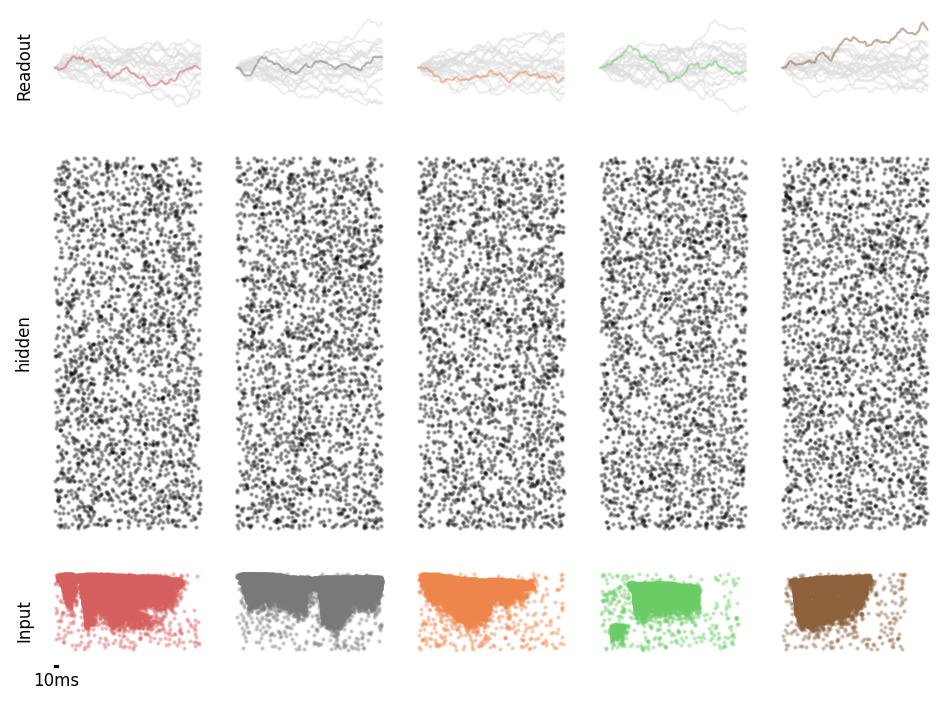

In [63]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model, data=test_dataset, nb_samples=5, point_alpha=0.3
)

## Train

It takes around 50 min using a powerful GPU

In [1]:
history = model.fit_validate(
    train_dataset, valid_dataset, nb_epochs=nb_epochs, verbose=True
)

NameError: name 'model' is not defined

In [ ]:
if "train_loss" in results:
    results["train_loss"] += history["loss"].tolist()
    results["train_acc"] += history["acc"].tolist()
    results["valid_loss"] += history["val_loss"].tolist()
    results["valid_acc"] += history["val_acc"].tolist()
else:
    results["train_loss"] = history["loss"].tolist()
    results["train_acc"] = history["acc"].tolist()
    results["valid_loss"] = history["val_loss"].tolist()
    results["valid_acc"] = history["val_acc"].tolist()

Monitor the model again after training

In [ ]:
res = model.monitor(test_dataset)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(nb_hidden_layers)]
results["avg_layer_freq"] = [
    nb / len(test_dataset) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

print(results["avg_layer_freq"])

[47.0639483294422]


## Test

In [ ]:
scores = model.evaluate(test_dataset).tolist()
results["test_loss"], _, results["test_acc"] = scores

Test loss:  0.6696678300698599
Test acc.:  0.84350887345679


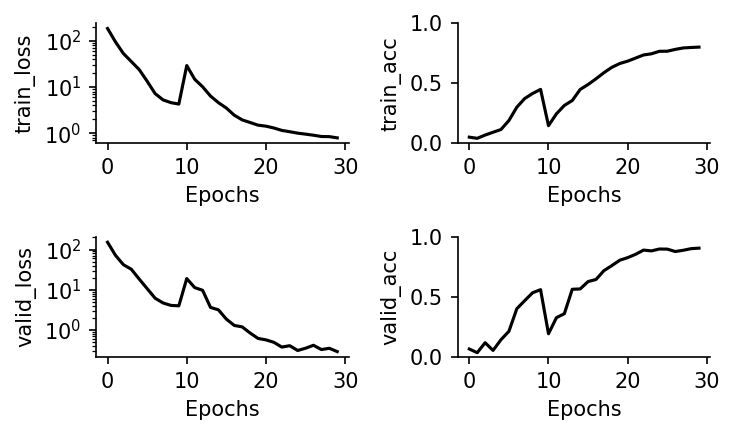

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(5, 3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):

    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i - 2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

    if "loss" in n:
        a.set_yscale("log")

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", results["test_acc"])

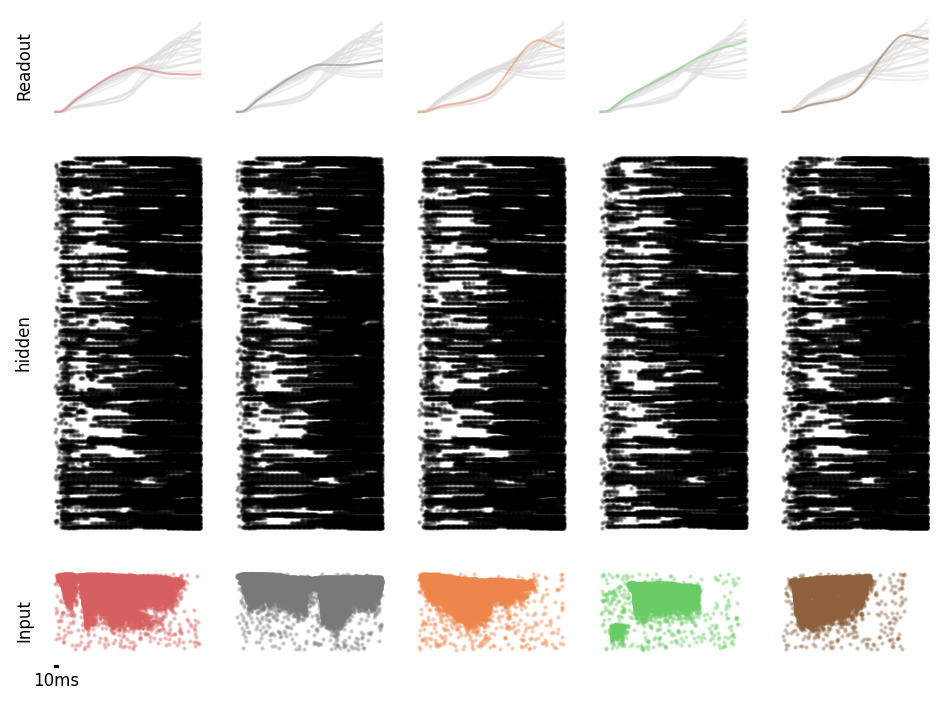

In [ ]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model, data=test_dataset, nb_samples=5, point_alpha=0.3
)